In [1]:
import polars as pl
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from vxx_trade.data_generator import generate_data_for_strategy
import matplotlib.pyplot as plt
import itertools
from scipy.stats import spearmanr

In [2]:
def foo():
    datagen = generate_data_for_strategy(verbose=False)
    df = datagen()

    features = [
        "volume",
        "vix_cp",
        "vvix_cp",
        "vol_ts",
        "vix_cp_ewma_zscore",
        "vvix_cp_ewma_zscore",
        "vol_ts_ewma_zscore",
    ]

    cols_to_keep = features + ["date", "vix_cp_rank", "vol_ts_rank", "vvix_cp_rank","vix_cp_zscore_bucket","vvix_cp_zscore_bucket","vol_ts_zscore_bucket","cc_ret"]

    scaling_features = features[:4]

    df = df.with_columns(
        [
            (pl.col(name) - pl.mean(name)) / pl.std(name) for name in scaling_features
        ]
    )
    df = df.select(cols_to_keep).drop_nulls()
    kmeans = KMeans(n_clusters=5, random_state=42)
    kmeans.fit(df.select(features).to_numpy())
    df = df.with_columns(pl.Series(kmeans.labels_.astype("int")).alias("KMeansCluster"))

    hierarchical_clustering = AgglomerativeClustering(n_clusters=5)
    hierarchical_clustering.fit(df.select(features).to_numpy())
    df = df.with_columns(
        pl.Series(hierarchical_clustering.labels_.astype("int")).alias(
            "HierarchicalCluster"
        )
    )

    gmm = GaussianMixture(n_components=5, random_state=42)  
    gmm.fit(df.select(features).to_numpy())
    df = df.with_columns(
        pl.Series(gmm.predict(df.select(features).to_numpy()).astype("int")).alias("GMMCluster")
    )

    return df 

In [3]:
datagen = generate_data_for_strategy(verbose=False)
df = datagen()

features = [
    "volume",
    "vix_cp",
    "vvix_cp",
    "vol_ts",
    "vix_cp_ewma_zscore",
    "vvix_cp_ewma_zscore",
    "vol_ts_ewma_zscore",
]

cols_to_keep = features + ["date", "vix_cp_rank", "vol_ts_rank", "vvix_cp_rank","vix_cp_zscore_bucket","vvix_cp_zscore_bucket","vol_ts_zscore_bucket","cc_ret"]

scaling_features = features[:4]

df = df.with_columns(
    [
        (pl.col(name) - pl.mean(name)) / pl.std(name) for name in scaling_features
    ]
)
df = df.select(cols_to_keep).drop_nulls()
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(df.select(features).to_numpy())
df = df.with_columns(pl.Series(kmeans.labels_.astype("int")).alias("KMeansCluster"))

hierarchical_clustering = AgglomerativeClustering(n_clusters=5)
hierarchical_clustering.fit(df.select(features).to_numpy())
df = df.with_columns(
    pl.Series(hierarchical_clustering.labels_.astype("int")).alias(
        "HierarchicalCluster"
    )
)

gmm = GaussianMixture(n_components=5, random_state=42)  
gmm.fit(df.select(features).to_numpy())
df = df.with_columns(
    pl.Series(gmm.predict(df.select(features).to_numpy()).astype("int")).alias("GMMCluster")
)


In [11]:
print(gmm)

GaussianMixture(n_components=5, random_state=42)


In [195]:
def plot_clusters(df):
    cluster_cols = ["KMeansCluster", "HierarchicalCluster", "GMMCluster", "vix_cp_rank"]

    for col in cluster_cols:
        print(df.group_by(col).agg(
            [
                pl.std("cc_ret").alias("std_cc_ret"),
                ((pl.col("cc_ret") ** 2).sum()).alias('vol'),
                pl.col("cc_ret").count().alias("GroupCount"),
            ]
        )
        .with_columns((pl.lit(16) * (pl.col('vol') / pl.col("GroupCount")).sqrt()).alias('vol'))
        .sort("std_cc_ret"))


In [196]:
def compute_ret_sharpe(df):
    cluster_cols = ["KMeansCluster", "HierarchicalCluster", "GMMCluster", "vix_cp_rank"]

    df = df.with_columns(
        [
            ((pl.col("cc_ret") ** 2).sum()).alias(f'vol_{col}').over(col) for col in cluster_cols
        ]
    ).with_columns(
        [
            pl.col("cc_ret").count().alias(f"GroupCount_{col}").over(col) for col in cluster_cols
        ]
    ).with_columns(
        [
            (pl.lit(16) * pl.col("cc_ret") /(pl.col(f'vol_{col}')/pl.col(f"GroupCount_{col}")).sqrt()).alias(f'{col}_sharpe') for col in cluster_cols
        ]
    )

    return df

In [197]:
df = foo()

In [198]:
plot_clusters(df)

shape: (5, 4)
┌───────────────┬────────────┬──────────┬────────────┐
│ KMeansCluster ┆ std_cc_ret ┆ vol      ┆ GroupCount │
│ ---           ┆ ---        ┆ ---      ┆ ---        │
│ i64           ┆ f32        ┆ f64      ┆ u32        │
╞═══════════════╪════════════╪══════════╪════════════╡
│ 4             ┆ 0.026718   ┆ 0.428046 ┆ 1090       │
│ 0             ┆ 0.03269    ┆ 0.52487  ┆ 890        │
│ 3             ┆ 0.045663   ┆ 0.731157 ┆ 466        │
│ 1             ┆ 0.054521   ┆ 0.872841 ┆ 500        │
│ 2             ┆ 0.090401   ┆ 1.446476 ┆ 147        │
└───────────────┴────────────┴──────────┴────────────┘
shape: (5, 4)
┌─────────────────────┬────────────┬──────────┬────────────┐
│ HierarchicalCluster ┆ std_cc_ret ┆ vol      ┆ GroupCount │
│ ---                 ┆ ---        ┆ ---      ┆ ---        │
│ i64                 ┆ f32        ┆ f64      ┆ u32        │
╞═════════════════════╪════════════╪══════════╪════════════╡
│ 2                   ┆ 0.02875    ┆ 0.460844 ┆ 1220       │
│

In [199]:
calc = compute_ret_sharpe(df)

In [200]:
df

volume,vix_cp,vvix_cp,vol_ts,vix_cp_ewma_zscore,vvix_cp_ewma_zscore,vol_ts_ewma_zscore,date,vix_cp_rank,vol_ts_rank,vvix_cp_rank,vix_cp_zscore_bucket,vvix_cp_zscore_bucket,vol_ts_zscore_bucket,cc_ret,KMeansCluster,HierarchicalCluster,GMMCluster
f64,f32,f32,f64,f32,f32,f64,date,u32,u32,u32,cat,cat,cat,f32,i64,i64,i64
0.046065,-0.218324,-0.118183,-0.516294,-1.22762,-0.480111,-0.978408,2012-07-18,6,4,6,"""(-1.5, -1]""","""(-0.5, 0]""","""(-1, -0.5]""",-0.023623,4,2,4
-0.052626,-0.323668,-0.136053,-0.826688,-1.424321,-0.49673,-1.770495,2012-07-19,5,3,6,"""(-1.5, -1]""","""(-0.5, 0]""","""(-2, -1.5]""",0.050496,4,2,4
0.352964,-0.202003,0.273758,-0.850786,-1.029748,0.44982,-1.716744,2012-07-20,6,2,7,"""(-1.5, -1]""","""(0, 0.5]""","""(-2, -1.5]""",0.063117,4,2,4
0.778042,0.14667,0.673442,-0.166953,-0.077099,1.308013,0.222489,2012-07-23,7,5,8,"""(-0.5, 0]""","""(1, 1.5]""","""(0, 0.5]""",0.041789,1,4,1
0.666231,0.421157,0.931361,0.378488,0.636342,1.77094,1.659415,2012-07-24,8,7,9,"""(0.5, 1]""","""(1.5, 2]""","""(1.5, 2]""",-0.014428,1,3,1
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
-0.968412,0.23866,0.720499,0.92444,0.140222,0.076387,0.443714,2024-10-23,8,9,8,"""(0, 0.5]""","""(0, 0.5]""","""(0, 0.5]""",-0.017085,3,3,3
-1.019362,0.214921,0.823547,0.939665,0.096099,0.170154,0.443061,2024-10-24,8,9,9,"""(0, 0.5]""","""(0, 0.5]""","""(0, 0.5]""",0.045892,3,3,3
-0.994622,0.400385,1.279819,1.069907,0.387519,0.597521,0.577615,2024-10-25,8,9,9,"""(0, 0.5]""","""(0.5, 1]""","""(0.5, 1]""",-0.047787,3,3,3


In [201]:
calc.describe()

statistic,volume,vix_cp,vvix_cp,vol_ts,vix_cp_ewma_zscore,vvix_cp_ewma_zscore,vol_ts_ewma_zscore,date,vix_cp_rank,vol_ts_rank,vvix_cp_rank,vix_cp_zscore_bucket,vvix_cp_zscore_bucket,vol_ts_zscore_bucket,cc_ret,KMeansCluster,HierarchicalCluster,GMMCluster,vol_KMeansCluster,vol_HierarchicalCluster,vol_GMMCluster,vol_vix_cp_rank,GroupCount_KMeansCluster,GroupCount_HierarchicalCluster,GroupCount_GMMCluster,GroupCount_vix_cp_rank,KMeansCluster_sharpe,HierarchicalCluster_sharpe,GMMCluster_sharpe,vix_cp_rank_sharpe
str,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",3093.0,3093.0,3093.0,3093.0,3093.0,3093.0,3093.0,"""3093""",3093.0,3093.0,3093.0,"""3093""","""3093""","""3093""",3093.0,3093.0,3093.0,3093.0,3093.0,3093.0,3093.0,3093.0,3093.0,3093.0,3093.0,3093.0,3093.0,3093.0,3093.0,3093.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0""",0.0,0.0,0.0,"""0""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",-0.010409,-0.00701,-0.004404,0.000798,-0.044132,-0.006829,-0.000297,"""2018-09-28 14:48:18.157000""",5.459425,5.495959,5.47462,null,null,null,-0.002675,2.118332,1.936954,1.853864,0.99477,1.089478,1.101784,0.536711,798.242806,903.14161,771.136437,309.484319,-1.102043,-1.183983,-1.027666,-1.042509
"""std""",1.004669,1.007279,1.00735,1.008483,1.147466,1.119027,1.119252,null,2.878757,2.892489,2.886784,null,null,null,0.041706,1.691112,0.985126,1.648233,0.240987,0.238188,0.477971,0.329917,289.161515,354.322746,209.912944,7.481683,15.964582,15.958714,15.969545,15.968582
"""min""",-1.154899,-1.259892,-2.040363,-2.13758,-2.530616,-2.565748,-3.69631,"""2012-07-18""",1.0,1.0,1.0,null,null,null,-0.213705,0.0,0.0,0.0,0.780131,0.659755,0.685645,0.179477,147.0,122.0,90.0,296.0,-63.410909,-63.721613,-65.8717,-62.591514
"""25%""",-0.782646,-0.651569,-0.718008,-0.700423,-0.8095,-0.718448,-0.781784,"""2015-09-03""",3.0,3.0,3.0,null,null,null,-0.024866,0.0,1.0,0.0,0.780131,1.012111,0.821376,0.235952,500.0,513.0,634.0,303.0,-11.106187,-11.149471,-10.709027,-10.755195
"""50%""",-0.179163,-0.293994,-0.22838,-0.109291,-0.316245,-0.200924,-0.158486,"""2018-10-02""",5.0,5.0,5.0,null,null,null,-0.0059,3.0,2.0,1.0,0.957752,1.044344,0.99922,0.437551,890.0,980.0,819.0,313.0,-2.908403,-2.891396,-2.757495,-2.902814
"""75%""",0.4141,0.35439,0.588264,0.583474,0.481628,0.501,0.638341,"""2021-10-27""",8.0,8.0,8.0,null,null,null,0.014488,4.0,2.0,4.0,0.973121,1.044344,0.99922,0.735208,1090.0,1220.0,1002.0,315.0,6.613134,6.494626,6.428534,6.299485
"""max""",8.174324,9.652829,6.646076,6.096869,7.400439,6.735384,6.252246,"""2024-10-29""",10.0,10.0,10.0,null,null,null,0.33085,4.0,4.0,4.0,1.487992,1.5699,2.0178,1.270969,1090.0,1220.0,1002.0,318.0,110.606451,102.734651,121.94822,107.125791


In [202]:
calc.describe()

statistic,volume,vix_cp,vvix_cp,vol_ts,vix_cp_ewma_zscore,vvix_cp_ewma_zscore,vol_ts_ewma_zscore,date,vix_cp_rank,vol_ts_rank,vvix_cp_rank,vix_cp_zscore_bucket,vvix_cp_zscore_bucket,vol_ts_zscore_bucket,cc_ret,KMeansCluster,HierarchicalCluster,GMMCluster,vol_KMeansCluster,vol_HierarchicalCluster,vol_GMMCluster,vol_vix_cp_rank,GroupCount_KMeansCluster,GroupCount_HierarchicalCluster,GroupCount_GMMCluster,GroupCount_vix_cp_rank,KMeansCluster_sharpe,HierarchicalCluster_sharpe,GMMCluster_sharpe,vix_cp_rank_sharpe
str,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",3093.0,3093.0,3093.0,3093.0,3093.0,3093.0,3093.0,"""3093""",3093.0,3093.0,3093.0,"""3093""","""3093""","""3093""",3093.0,3093.0,3093.0,3093.0,3093.0,3093.0,3093.0,3093.0,3093.0,3093.0,3093.0,3093.0,3093.0,3093.0,3093.0,3093.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0""",0.0,0.0,0.0,"""0""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",-0.010409,-0.00701,-0.004404,0.000798,-0.044132,-0.006829,-0.000297,"""2018-09-28 14:48:18.157000""",5.459425,5.495959,5.47462,null,null,null,-0.002675,2.118332,1.936954,1.853864,0.99477,1.089478,1.101784,0.536711,798.242806,903.14161,771.136437,309.484319,-1.102043,-1.183983,-1.027666,-1.042509
"""std""",1.004669,1.007279,1.00735,1.008483,1.147466,1.119027,1.119252,null,2.878757,2.892489,2.886784,null,null,null,0.041706,1.691112,0.985126,1.648233,0.240987,0.238188,0.477971,0.329917,289.161515,354.322746,209.912944,7.481683,15.964582,15.958714,15.969545,15.968582
"""min""",-1.154899,-1.259892,-2.040363,-2.13758,-2.530616,-2.565748,-3.69631,"""2012-07-18""",1.0,1.0,1.0,null,null,null,-0.213705,0.0,0.0,0.0,0.780131,0.659755,0.685645,0.179477,147.0,122.0,90.0,296.0,-63.410909,-63.721613,-65.8717,-62.591514
"""25%""",-0.782646,-0.651569,-0.718008,-0.700423,-0.8095,-0.718448,-0.781784,"""2015-09-03""",3.0,3.0,3.0,null,null,null,-0.024866,0.0,1.0,0.0,0.780131,1.012111,0.821376,0.235952,500.0,513.0,634.0,303.0,-11.106187,-11.149471,-10.709027,-10.755195
"""50%""",-0.179163,-0.293994,-0.22838,-0.109291,-0.316245,-0.200924,-0.158486,"""2018-10-02""",5.0,5.0,5.0,null,null,null,-0.0059,3.0,2.0,1.0,0.957752,1.044344,0.99922,0.437551,890.0,980.0,819.0,313.0,-2.908403,-2.891396,-2.757495,-2.902814
"""75%""",0.4141,0.35439,0.588264,0.583474,0.481628,0.501,0.638341,"""2021-10-27""",8.0,8.0,8.0,null,null,null,0.014488,4.0,2.0,4.0,0.973121,1.044344,0.99922,0.735208,1090.0,1220.0,1002.0,315.0,6.613134,6.494626,6.428534,6.299485
"""max""",8.174324,9.652829,6.646076,6.096869,7.400439,6.735384,6.252246,"""2024-10-29""",10.0,10.0,10.0,null,null,null,0.33085,4.0,4.0,4.0,1.487992,1.5699,2.0178,1.270969,1090.0,1220.0,1002.0,318.0,110.606451,102.734651,121.94822,107.125791


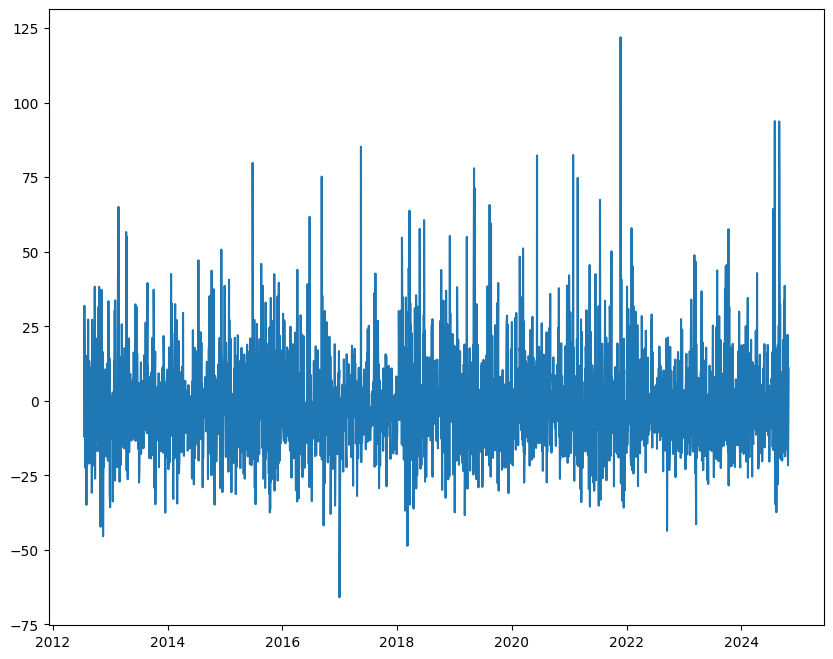

In [203]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(calc.get_column('date'), calc.get_column('GMMCluster_sharpe'))

In [204]:
def calculate_spearman_correlation_polars(df, col1, col2):
    """
    Calculates the Spearman correlation coefficient between two columns of a Polars DataFrame.

    Args:
        df (pl.DataFrame): The Polars DataFrame.
        col1 (str): The name of the first column.
        col2 (str): The name of the second column.

    Returns:
        tuple: A tuple containing the Spearman correlation coefficient and the p-value.
    """
    

    series1 = df.select(col1).to_series()
    series2 = df.select(col2).to_series()
    correlation, p_value = spearmanr(series1, series2)
    print(f'{col1} correlation with {col2} is {correlation:.3f}')
    return correlation, p_value

In [205]:
cols = "KMeansCluster_sharpe HierarchicalCluster_sharpe GMMCluster_sharpe vix_cp_rank_sharpe".split()
for col1, col2 in list(itertools.combinations(cols, 2)):
    calculate_spearman_correlation_polars(calc, col1, col2)

KMeansCluster_sharpe correlation with HierarchicalCluster_sharpe is 0.994
KMeansCluster_sharpe correlation with GMMCluster_sharpe is 0.988
KMeansCluster_sharpe correlation with vix_cp_rank_sharpe is 0.984
HierarchicalCluster_sharpe correlation with GMMCluster_sharpe is 0.990
HierarchicalCluster_sharpe correlation with vix_cp_rank_sharpe is 0.983
GMMCluster_sharpe correlation with vix_cp_rank_sharpe is 0.984


In [206]:
calc = calc.with_columns([
    

            (
                (
                    pl.col(column).rank(method="max", descending=False)
                    / df.height
                    * 10
                )
                .ceil()
                .cast(pl.UInt32)
                .alias(f"{column}_rank")
            )
for column in cols]
        )

In [207]:
df = calc

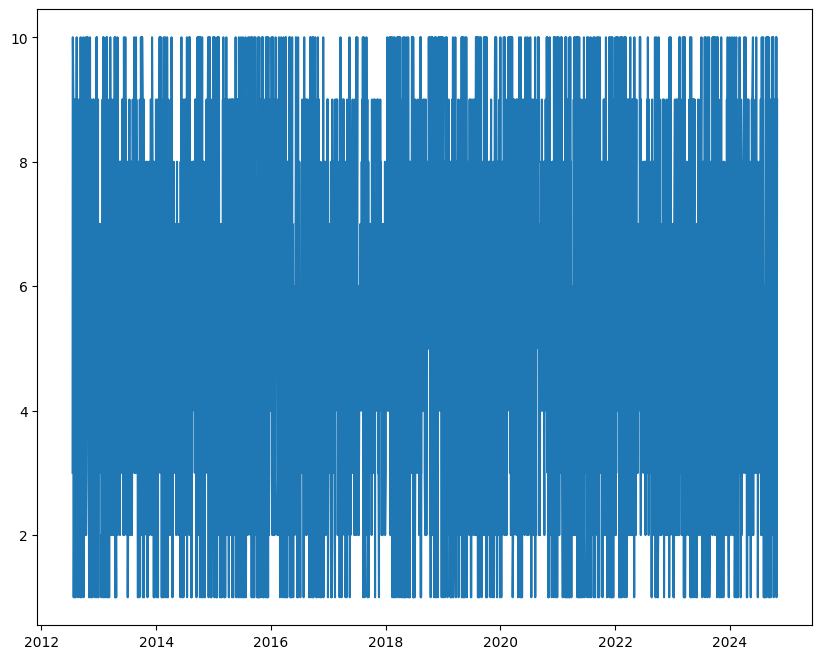

In [208]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(df.get_column('date'), calc.get_column('GMMCluster_sharpe_rank'))

In [209]:
df = df.with_columns((-2.2 + pl.col("KMeansCluster_sharpe_rank") / 5).alias('pos'))
df = df.with_columns((pl.col('pos') * pl.col('cc_ret')).alias('strategy_ret'))
df = df.with_columns((pl.col('cc_ret') * -1).alias('naive_ret'))
df = df.with_columns(pl.col("strategy_ret").cum_sum().alias('strategy'))
df = df.with_columns(pl.col("naive_ret").cum_sum().alias('naive'))

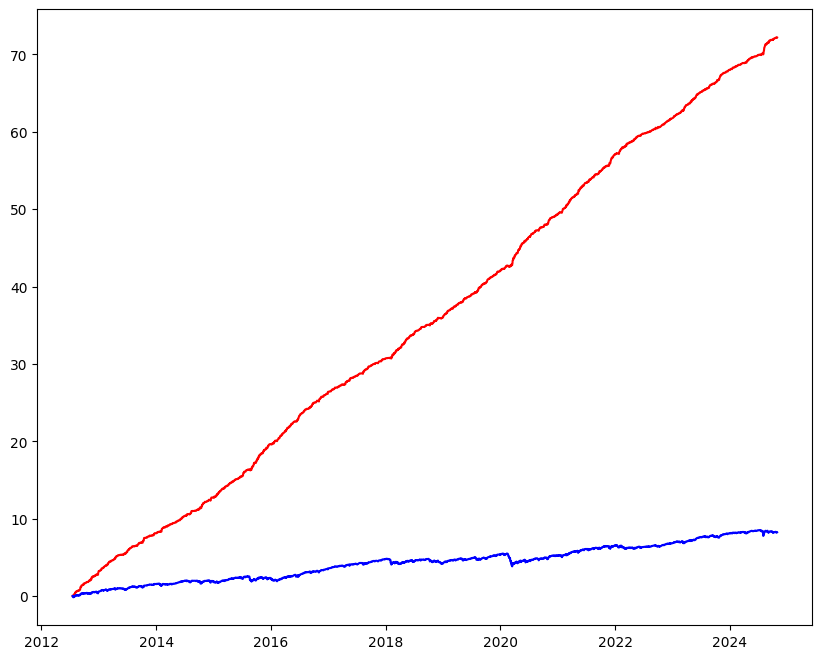

In [210]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(df.get_column('date'), df.get_column('strategy'), color='red')
ax.plot(df.get_column('date'), df.get_column('naive'), color='blue')

In [211]:
features1 = ['vix_cp_rank', 'vol_ts_rank', 'vvix_cp_rank', 'vix_cp_zscore_bucket', 'vol_ts_zscore_bucket', 'vvix_cp_zscore_bucket']
features2 = ["volume", "vix_cp", "vvix_cp", "vol_ts", "vix_cp_ewma_zscore", "vvix_cp_ewma_zscore", "vol_ts_ewma_zscore"]

In [212]:
df.select(['vix_cp_zscore_bucket', 'vol_ts_zscore_bucket', 'vvix_cp_zscore_bucket'])

vix_cp_zscore_bucket,vol_ts_zscore_bucket,vvix_cp_zscore_bucket
cat,cat,cat
"""(-1.5, -1]""","""(-1, -0.5]""","""(-0.5, 0]"""
"""(-1.5, -1]""","""(-2, -1.5]""","""(-0.5, 0]"""
"""(-1.5, -1]""","""(-2, -1.5]""","""(0, 0.5]"""
"""(-0.5, 0]""","""(0, 0.5]""","""(1, 1.5]"""
"""(0.5, 1]""","""(1.5, 2]""","""(1.5, 2]"""
…,…,…
"""(0, 0.5]""","""(0, 0.5]""","""(0, 0.5]"""
"""(0, 0.5]""","""(0, 0.5]""","""(0, 0.5]"""
"""(0, 0.5]""","""(0.5, 1]""","""(0.5, 1]"""


In [222]:
import datetime 
train = df.filter(pl.col('date').le(datetime.datetime(2020,12,31)))
test = df.filter(pl.col('date').gt(datetime.datetime(2020,12,31)))#.and_(pl.col('date').le(datetime.datetime(2024,1,1))))

In [239]:
train

volume,vix_cp,vvix_cp,vol_ts,vix_cp_ewma_zscore,vvix_cp_ewma_zscore,vol_ts_ewma_zscore,date,vix_cp_rank,vol_ts_rank,vvix_cp_rank,vix_cp_zscore_bucket,vvix_cp_zscore_bucket,vol_ts_zscore_bucket,cc_ret,KMeansCluster,HierarchicalCluster,GMMCluster,vol_KMeansCluster,vol_HierarchicalCluster,vol_GMMCluster,vol_vix_cp_rank,GroupCount_KMeansCluster,GroupCount_HierarchicalCluster,GroupCount_GMMCluster,GroupCount_vix_cp_rank,KMeansCluster_sharpe,HierarchicalCluster_sharpe,GMMCluster_sharpe,vix_cp_rank_sharpe,KMeansCluster_sharpe_rank,HierarchicalCluster_sharpe_rank,GMMCluster_sharpe_rank,vix_cp_rank_sharpe_rank,pos,strategy_ret,naive_ret,strategy,naive
f64,f32,f32,f64,f32,f32,f64,date,u32,u32,u32,cat,cat,cat,f32,i64,i64,i64,f32,f32,f32,f32,u32,u32,u32,u32,f64,f64,f64,f64,u32,u32,u32,u32,f64,f64,f32,f64,f32
0.046065,-0.218324,-0.118183,-0.516294,-1.22762,-0.480111,-0.978408,2012-07-18,6,4,6,"""(-1.5, -1]""","""(-0.5, 0]""","""(-1, -0.5]""",-0.023623,4,2,4,0.780131,1.012111,0.821376,0.53535,1090,1220,819,308,-14.1284,-13.12289,-11.935334,-9.066091,2,3,3,3,-1.8,0.042522,0.023623,0.042522,0.023623
-0.052626,-0.323668,-0.136053,-0.826688,-1.424321,-0.49673,-1.770495,2012-07-19,5,3,6,"""(-1.5, -1]""","""(-0.5, 0]""","""(-2, -1.5]""",0.050496,4,2,4,0.780131,1.012111,0.821376,0.437551,1090,1220,819,315,30.200019,28.050701,25.512252,21.67798,10,10,10,10,-0.2,-0.010099,-0.050496,0.032423,-0.026873
0.352964,-0.202003,0.273758,-0.850786,-1.029748,0.44982,-1.716744,2012-07-20,6,2,7,"""(-1.5, -1]""","""(0, 0.5]""","""(-2, -1.5]""",0.063117,4,2,4,0.780131,1.012111,0.821376,0.53535,1090,1220,819,308,37.74817,35.061654,31.88875,24.222724,10,10,10,10,-0.2,-0.012623,-0.063117,0.0198,-0.08999
0.778042,0.14667,0.673442,-0.166953,-0.077099,1.308013,0.222489,2012-07-23,7,5,8,"""(-0.5, 0]""","""(1, 1.5]""","""(0, 0.5]""",0.041789,1,4,1,1.487992,0.659755,2.0178,0.880716,500,258,634,297,12.256521,13.222118,11.851902,12.278432,9,9,9,9,-0.4,-0.016716,-0.041789,0.003084,-0.131779
0.666231,0.421157,0.931361,0.378488,0.636342,1.77094,1.659415,2012-07-24,8,7,9,"""(0.5, 1]""","""(1.5, 2]""","""(1.5, 2]""",-0.014428,1,3,1,1.487992,1.5699,2.0178,0.580675,500,513,634,303,-4.231701,-4.173044,-4.092002,-5.273331,5,5,5,5,-1.2,0.017314,0.014428,0.020398,-0.117351
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
-0.676984,0.578431,1.146392,-0.578052,-0.636985,0.028152,-0.784598,2020-12-24,8,4,9,"""(-1, -0.5]""","""(0, 0.5]""","""(-1, -0.5]""",-0.003561,3,4,4,0.973121,0.659755,0.821376,0.580675,466,258,819,303,-1.246821,-1.126712,-1.799142,-1.301515,6,6,6,6,-1.0,0.003561,0.003561,49.292298,5.275953
-0.470764,0.603654,1.095166,-0.386829,-0.566286,-0.049116,-0.515804,2020-12-28,9,4,9,"""(-1, -0.5]""","""(-0.5, 0]""","""(-1, -0.5]""",0.035625,3,4,4,0.973121,0.659755,0.821376,0.735208,466,258,819,296,12.473215,11.271645,17.998644,11.436934,9,9,10,9,-0.4,-0.01425,-0.035625,49.278048,5.240329
0.082703,0.808406,1.206553,-0.160996,-0.20589,0.120797,-0.218038,2020-12-29,9,5,9,"""(-0.5, 0]""","""(0, 0.5]""","""(-0.5, 0]""",-0.036814,3,4,4,0.973121,0.659755,0.821376,0.735208,466,258,819,296,-12.889768,-11.648071,-18.599723,-11.81888,3,3,1,3,-1.6,0.058903,0.036814,49.336951,5.277143


In [300]:
from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from xgboost import XGBClassifier

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
model = RandomForestClassifier(random_state=42)

In [301]:
param_space = {
    'n_estimators': Integer(50, 1000),
    'max_depth': Integer(3, 10),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Real(1e-2, 1e-1, prior='log-uniform'),
    'criterion': Categorical(['gini', 'entropy', 'log_loss']),
    'max_features': Categorical(['log2', 'sqrt'])
}
model2 = BayesSearchCV(
    RandomForestClassifier(),
    param_space,
    n_iter=25,
    cv=5,
    random_state=42,
    scoring='accuracy', 
    verbose=True
)
param_grid = {
    'learning_rate': Real(0.01, 1.0, prior='log-uniform'),
    'n_estimators': Integer(50, 1000),
    'max_depth': Integer(3, 10),
    'subsample': Real(0.5, 1.0),
    'colsample_bytree': Real(0.5, 1.0)
}
model3 = BayesSearchCV(
    XGBClassifier(),
    param_grid,
    n_iter=25,  
    cv=5,
    random_state=42,
    scoring='accuracy', 
    verbose=True
)


In [291]:
train = train.with_columns(xgboost_target=(pl.col('vix_cp_rank_sharpe_rank') - pl.lit(1)))
test = test.with_columns(xgboost_target=(pl.col('vix_cp_rank_sharpe_rank') - pl.lit(1)))

In [ ]:
# model.fit(train.select(features2), train.get_column("vix_cp_rank_sharpe_rank"))
# model2.fit(train.select(features2), train.get_column("vix_cp_rank_sharpe_rank"))
model3.fit(train.select(features2), train.get_column("xgboost_target"))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [260]:
y_pred = model.predict(test.select(features2))
y_pred2 = model2.predict(test.select(features2))
y_pred3 = model3.predict(test.select(features2))
# test=test.with_columns(pl.Series(y_pred).alias('pred'))
# test=test.with_columns(pl.Series(y_pred2).alias('pred2'))

In [261]:
test = test.with_columns((-2.2 + pl.col("pred") / 5).alias('pos'))
test = test.with_columns((-2.2 + pl.col("pred2") / 5).alias('pos2'))
test = test.with_columns((pl.col('pos') * pl.col('cc_ret')).alias('strategy_ret'))
test = test.with_columns((pl.col('pos2') * pl.col('cc_ret')).alias('strategy_ret2'))
test = test.with_columns((pl.col('cc_ret') * -1).alias('naive_ret'))
test = test.with_columns(pl.col("strategy_ret").cum_sum().alias('strategy'))
test = test.with_columns(pl.col("strategy_ret2").cum_sum().alias('strategy2'))
test = test.with_columns(pl.col("naive_ret").cum_sum().alias('naive'))

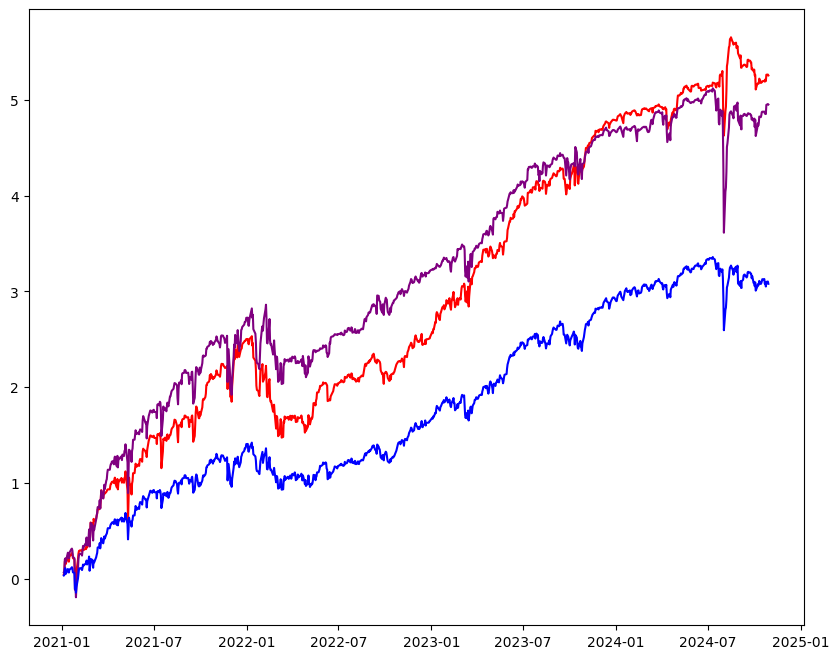

In [262]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(test.get_column('date'), test.get_column('strategy'), color='red')
ax.plot(test.get_column('date'), test.get_column('strategy2'), color='purple')
ax.plot(test.get_column('date'), test.get_column('naive'), color='blue')

In [263]:
test.select(['strategy_ret', 'strategy_ret2','naive_ret']).describe()

statistic,strategy_ret,strategy_ret2,naive_ret
str,f64,f64,f64
"""count""",980.0,980.0,980.0
"""null_count""",0.0,0.0,0.0
"""mean""",0.005361,0.005051,0.003141
"""std""",0.057611,0.070604,0.04111
"""min""",-0.431743,-0.661699,-0.33085
"""25%""",-0.010749,-0.013364,-0.015282
"""50%""",0.004106,0.004596,0.006604
"""75%""",0.024792,0.024483,0.025668
"""max""",0.341838,0.42741,0.213705


In [231]:
(0.004466 / 0.053346) * 16

1.3394818730551497